In [3]:
import pandas as pd
import numpy as np
import sklearn as skl
from sklearn import linear_model, svm, neighbors, preprocessing, metrics, model_selection, ensemble, multiclass
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import random
from collections import Counter
from tqdm.notebook import tqdm
from imblearn.ensemble import BalancedRandomForestClassifier
import imblearn
from sqlalchemy import create_engine
import xgboost as xgb

In [4]:
RANDOM_STATE = 789
genres_df = pd.read_csv("src/data/genres_v2.csv")
playlist_df = pd.read_csv("src/data/playlists.csv")

# data cleaning
take_notna = lambda s1,s2: s1 if type(s1) == str else s2
genres_df["song_title"]=genres_df["song_name"].combine(genres_df["title"],take_notna, fill_value=None)
genres_df.drop(columns = ["song_name","title","Unnamed: 0"], inplace=True)
genres_df.dropna(inplace=True)
# changing dtype
genres_df["key"] = genres_df["key"].astype(int)
genres_df["mode"] = genres_df["mode"].astype(int)
genres_df["duration_ms"] = genres_df["duration_ms"].astype(int)
genres_df["time_signature"] = genres_df["time_signature"].astype(int)
# selecting columns to use
valid_columns = ["danceability","energy","key","loudness","mode","speechiness","acousticness","instrumentalness",
                "liveness","valence","tempo","duration_ms","time_signature","genre"]
genres_df = genres_df[valid_columns].reset_index(drop=True)

genres_df.head()

C:\Users\yahoy\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\IPython\core\interactiveshell.py:3156: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.831   0.814    2    -7.364     1       0.4200        0.0598   
1         0.719   0.493    8    -7.230     1       0.0794        0.4010   
2         0.850   0.893    5    -4.783     1       0.0623        0.0138   
3         0.476   0.781    0    -4.710     1       0.1030        0.0237   
4         0.798   0.624    2    -7.668     1       0.2930        0.2170   

   instrumentalness  liveness  valence    tempo  duration_ms  time_signature  \
0          0.013400    0.0556   0.3890  156.985       124539               4   
1          0.000000    0.1180   0.1240  115.080       224427               4   
2          0.000004    0.3720   0.0391  218.050        98821               4   
3          0.000000    0.1140   0.1750  186.948       123661               3   
4          0.000000    0.1660   0.5910  147.988       123298               4   

       genre  
0  Dark Trap  
1  Dark Trap  
2  Dark Trap  
3  Dark Trap  
4  Dark Trap

In [31]:
def query_from_engine(statement, eng = engine, columns=None):
    conn = eng.connect()
    result = conn.execute(statement).fetchall()
    df = pd.DataFrame(result)
    if columns:
        df.columns = columns
    return df

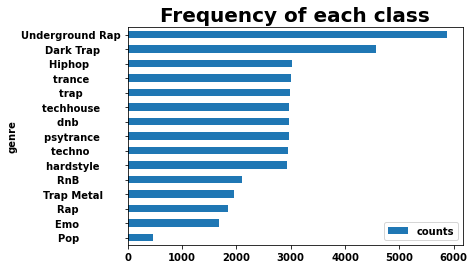

In [30]:
# plot the number of samples belonging to each class
engine = create_engine("postgresql://postgres:{}@localhost:5432/music".format(password))

query = """SELECT genre, COUNT(*) as counts
FROM genres_main
GROUP BY genre
ORDER BY counts DESC"""
genre_counts = query_from_engine(query)
genre_counts.columns = ["genre","counts"]
genre_counts.sort_values("counts", inplace = True)
genre_counts.set_index("genre", inplace = True)
genre_counts.plot(kind="barh")
plt.title("Frequency of each class",fontsize =20);
plt.savefig("src/image/class_freq.png", transparent=True)

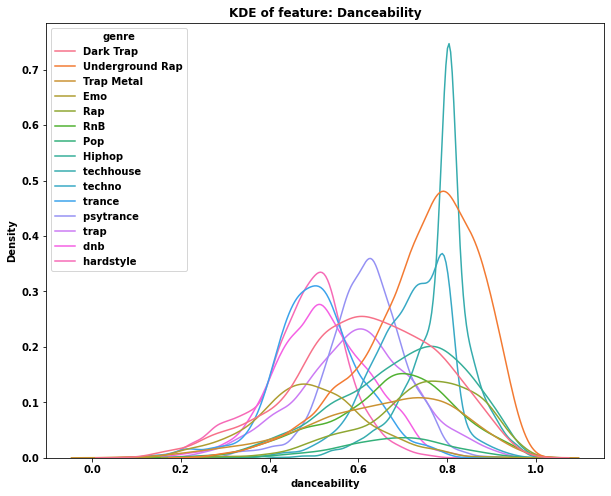

In [34]:
# plotting kde to observe the distribution
plt.figure(figsize = (10,8))
query = """SELECT danceability, genre FROM genres_main"""
df = query_from_engine(query, columns = ["danceability","genre"])
sns.kdeplot(data= df, x = "danceability", hue = "genre");
plt.title("KDE of feature: Danceability");
plt.savefig("src/image/danceability_kde.png", transparent = True)

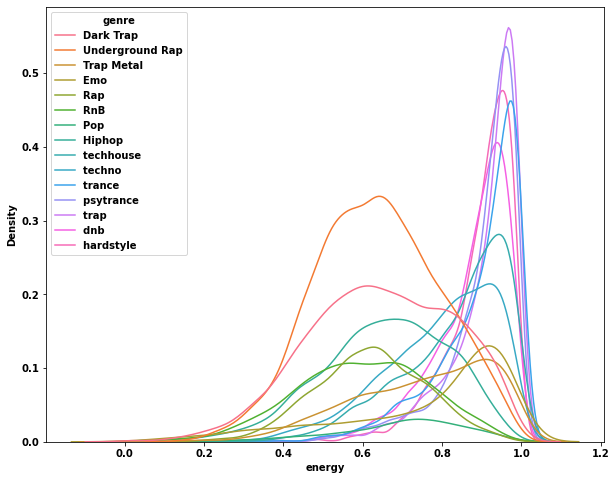

In [36]:
plt.figure(figsize = (10,8))
query = """SELECT energy, genre FROM genres_main"""
df = query_from_engine(query, columns = ["energy","genre"])
sns.kdeplot(data= df, x = "energy", hue = "genre");

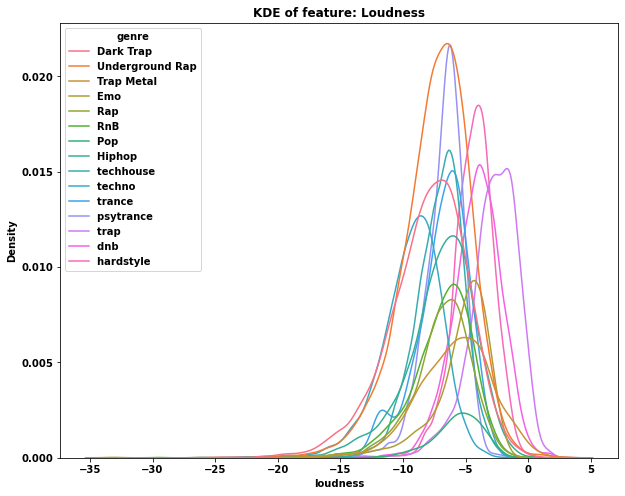

In [38]:
plt.figure(figsize = (10,8))
query = """SELECT loudness, genre FROM genres_main"""
df = query_from_engine(query, columns = ["loudness","genre"])
sns.kdeplot(data= df, x = "loudness", hue = "genre");
plt.title("KDE of feature: Loudness");
plt.savefig("src/image/kde_loudness.png", transparent = True)

In [40]:
# violin plot all numeric features between classes
numeric_features = [c for c in genres_df.columns if genres_df[c].dtype == float or genres_df[c].dtype == int]
nonnumeric_features = [c for c in genres_df.columns if genres_df[c].dtype != float and genres_df[c].dtype != int]

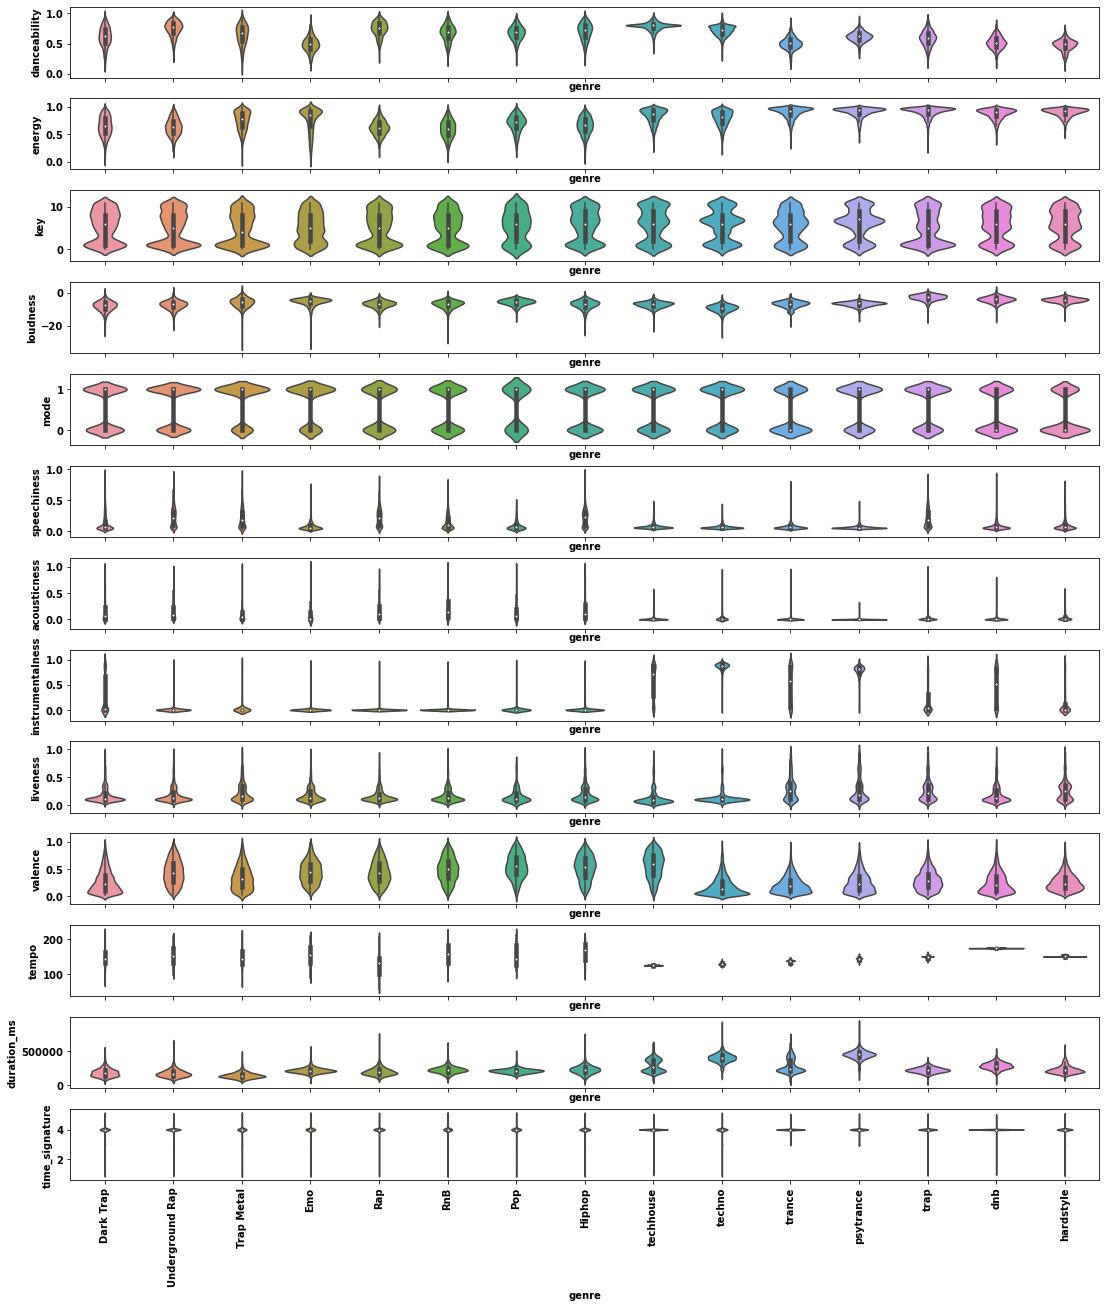

In [4]:
fig, axs = plt.subplots(nrows = len(numeric_features), figsize = (15,17), sharex= True)
plt.subplots_adjust(hspace = 0.4, bottom=0.05, left = 0.3)
plt.xticks(rotation=90)
plt.tight_layout()
for i, ax in enumerate(axs):
    
    sns.violinplot(data = genres_df, x = "genre", y = numeric_features[i], ax = ax)
plt.savefig("src/image/violinplot.png", dpi=300)
plt.show()

# Part 1
### data prep

In [43]:
# get the data
query = """SELECT {} FROM genres_main""".format( ", ".join(numeric_features))

genres_df = query_from_engine(query, columns = numeric_features)

# splitting dataframe into x and y
X = genres_df.iloc[:,:-1]
y = genres_df.iloc[:,-1:]



# splitting into train and test
train_x, test_x, train_y, test_y  = model_selection.train_test_split(X,y,shuffle=True,
                                                                     random_state = RANDOM_STATE) #defaults to .75&.25

# splitting into train and test (stratified): all classes are ~ same sizes
strf_train_x, strf_test_x, strf_train_y, strf_test_y = model_selection.train_test_split(X,y,
                                                                                       stratify = y.values)

# reset index for all
train_x.reset_index(drop=True, inplace=True)
train_y.reset_index(drop=True, inplace=True)
test_x.reset_index(drop=True, inplace=True)
test_y.reset_index(drop=True, inplace=True)

strf_train_x.reset_index(drop=True, inplace=True)
strf_train_y.reset_index(drop=True, inplace=True)
strf_test_x.reset_index(drop=True, inplace=True)
strf_test_y.reset_index(drop=True, inplace=True)


print("shape of train and test x: {},{}".format(train_x.shape, test_x.shape))
print("shape of train and test y: {},{}".format(train_y.shape, test_y.shape))
print("shape of stratified train and test x: {},{}".format(strf_train_x.shape, strf_test_x.shape))
print("shape of stratified train and test y: {},{}".format(strf_train_y.shape, strf_test_y.shape))


shape of train and test x: (31724, 12),(10575, 12)
shape of train and test y: (31724, 1),(10575, 1)
shape of stratified train and test x: (31724, 12),(10575, 12)
shape of stratified train and test y: (31724, 1),(10575, 1)


In [8]:
# binarize target variables
target_lb = preprocessing.LabelBinarizer()
bin_train_y = target_lb.fit_transform(train_y)
bin_test_y = target_lb.transform(test_y)
# do the same for strf
strf_target_lb = preprocessing.LabelBinarizer()
strf_bin_train_y = strf_target_lb.fit_transform(strf_train_y)
strf_bin_test_y = strf_target_lb.transform(strf_test_y)

# ordinal encode target vars
oe = preprocessing.OrdinalEncoder()
oe_train_y = oe.fit_transform(train_y)
oe_test_y = oe.transform(test_y)

strf_oe = preprocessing.OrdinalEncoder()
strf_oe_train_y = strf_oe.fit_transform(strf_train_y)
strf_oe_test_y = strf_oe.transform(strf_test_y)

In [9]:
# shapes of binarized and ordianl encoded Ys
# either regularly splitted or stratified
print(bin_train_y.shape, strf_bin_train_y.shape, oe_train_y.shape, strf_oe_train_y.shape)

(31724, 15) (31724, 15) (31724, 1) (31724, 1)


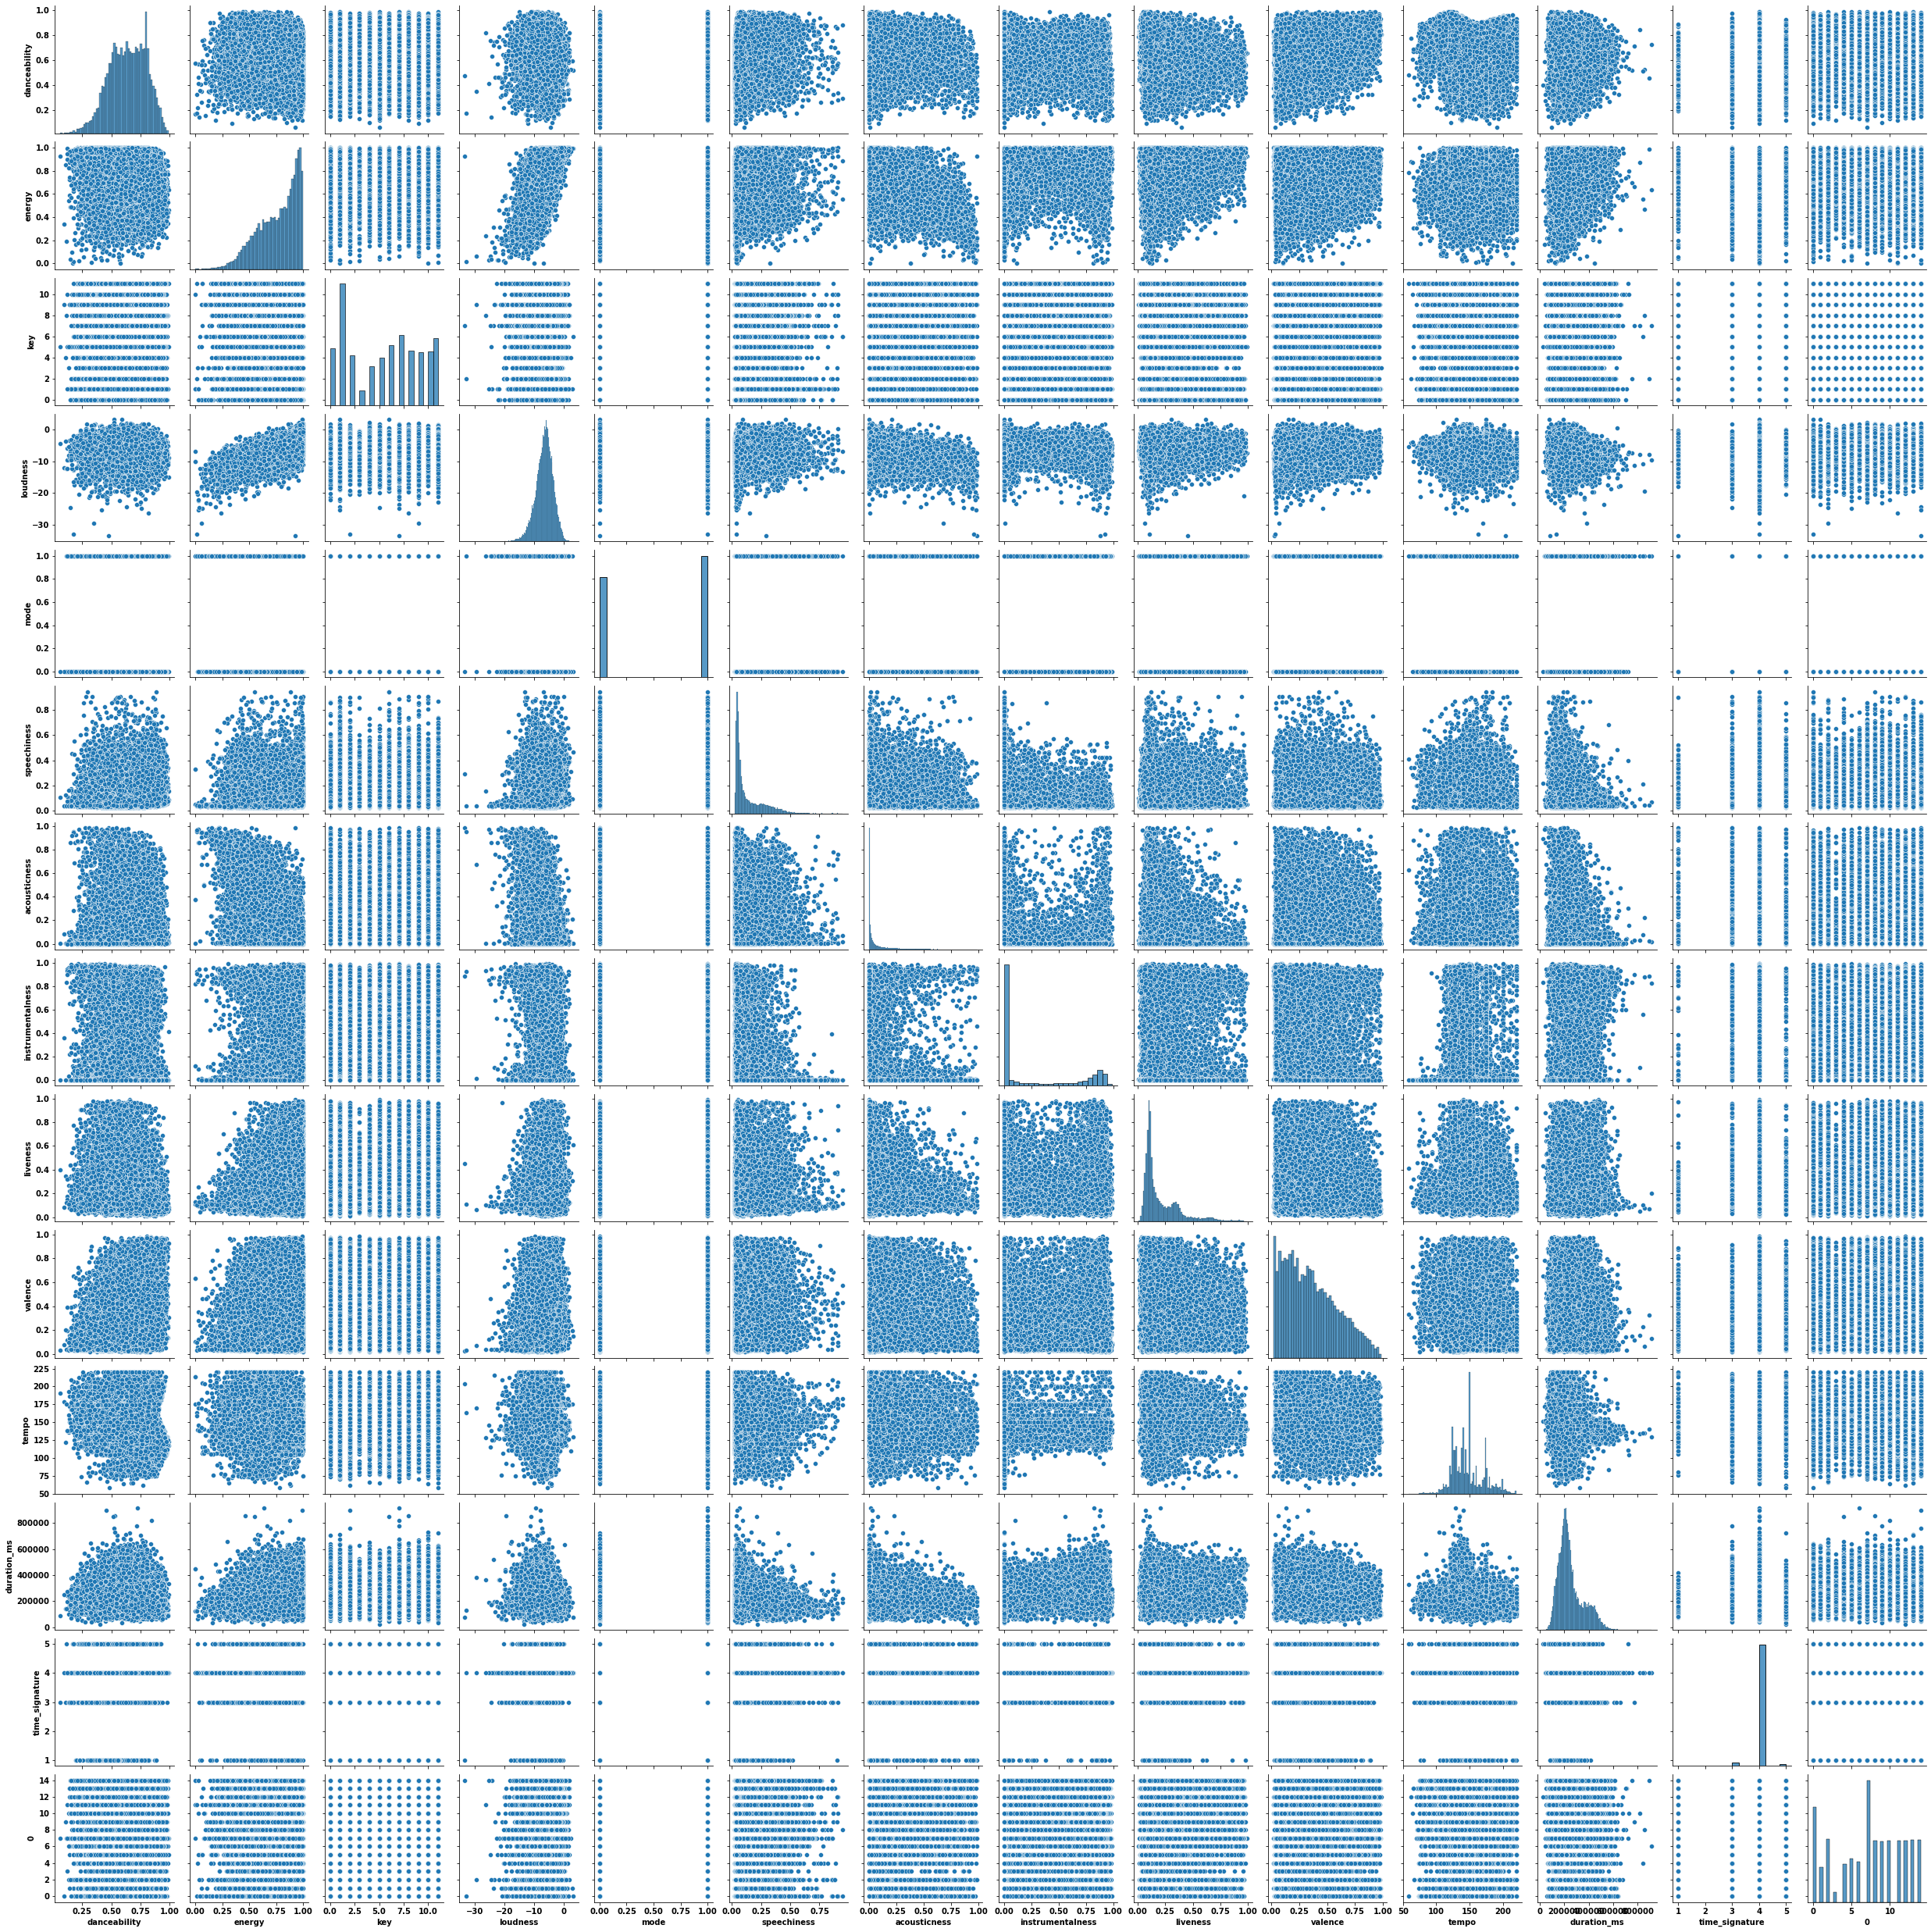

In [124]:
# pair plot for each features
sns.pairplot(pd.concat([train_x, pd.DataFrame(strf_oe_train_y)], axis = 1))

the pairplot above shows that no feature has direct relationship to target variable

# Part 2: Models

## 2.1KNN

In [10]:
# ordinary train and test sets
ord_trains = [train_x, train_y]
ord_tests = [test_x, test_y]

# labeled target variables
modified_train_ys = [bin_train_y, oe_train_y] # bin_*_y.shape: N*15
modified_test_ys  = [bin_test_y, oe_test_y] #shape: N*1

# stratified train and test sets
strf_trains = [strf_train_x, strf_train_y]
strf_tests = [strf_test_x, strf_test_y]
# labeled strf target variables
strf_modified_train_ys = [strf_bin_train_y, strf_oe_train_y] # same as above
strf_modified_test_ys = [strf_bin_test_y,strf_oe_test_y]

In [11]:

knn_bin = neighbors.KNeighborsClassifier(n_neighbors = 10)
knn_bin.fit(train_x, modified_train_ys[0]) # y is one hot encoded
bin_train_pred = knn_bin.predict(train_x)
bin_test_pred = knn_bin.predict(test_x)


knn_oe = neighbors.KNeighborsClassifier(n_neighbors = 10)
knn_oe.fit(train_x, modified_train_ys[1].ravel()) # y is (n_samples,)
oe_train_pred = knn_oe.predict(train_x)
oe_test_pred = knn_oe.predict(test_x)


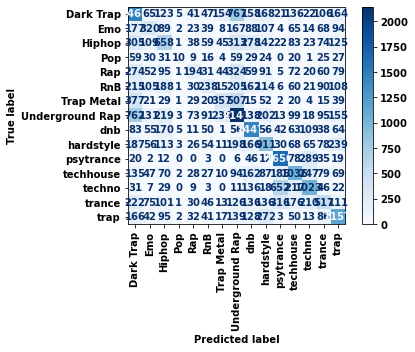

In [157]:
# confusion matrix on train dataset on knn
confmat = metrics.plot_confusion_matrix(knn_oe, train_x, modified_train_ys[1],
                              display_labels = oe.categories_[0],
                             xticks_rotation = "vertical",
                             cmap=plt.cm.Blues,
                             )

plt.show()

In [164]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=(15,15),
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

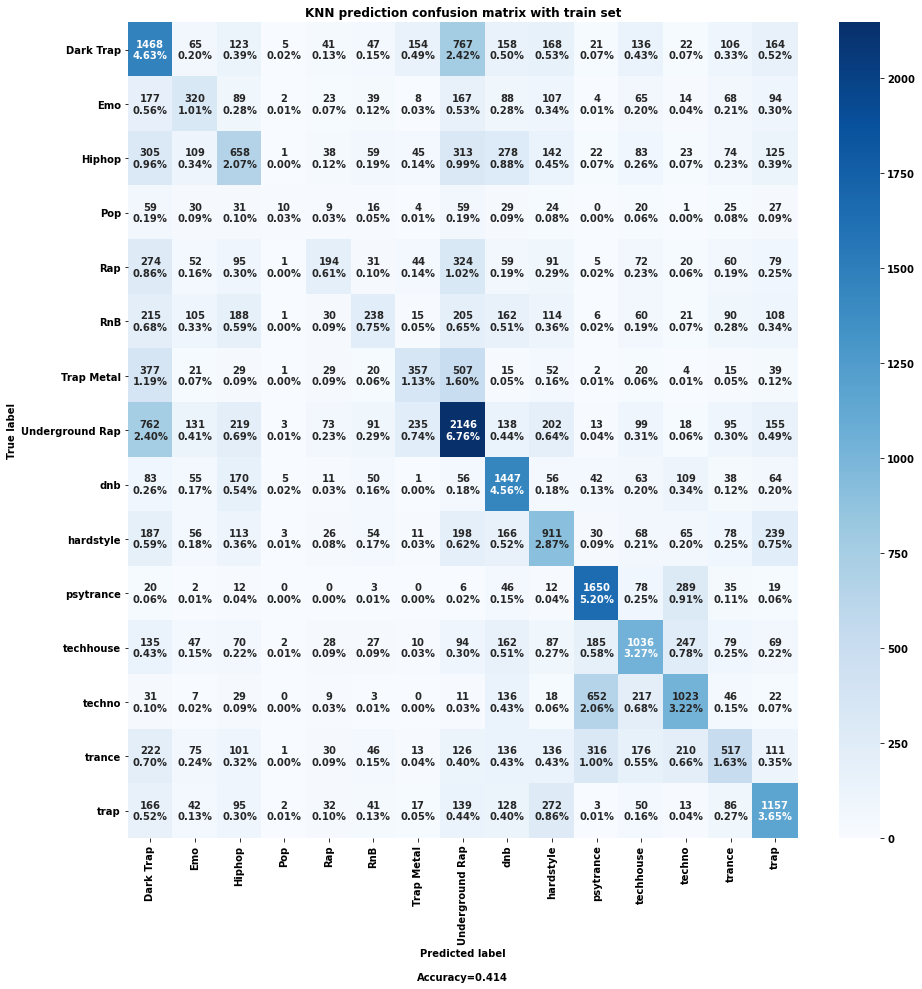

In [166]:
make_confusion_matrix(metrics.confusion_matrix(modified_train_ys[1], y_pred=oe_train_pred), 
                      categories= oe.categories_[0], cmap="Blues",title="KNN prediction confusion matrix with train set")

In [99]:
print("KNN train set")
print(metrics.classification_report(modified_train_ys[1], knn_oe.predict(train_x),target_names = oe.categories_[0]))

KNN train set
                 precision    recall  f1-score   support

      Dark Trap       0.33      0.43      0.37      3445
            Emo       0.29      0.25      0.27      1265
         Hiphop       0.33      0.29      0.31      2275
            Pop       0.27      0.03      0.05       344
            Rap       0.34      0.14      0.20      1401
            RnB       0.31      0.15      0.20      1558
     Trap Metal       0.39      0.24      0.30      1488
Underground Rap       0.42      0.49      0.45      4380
            dnb       0.46      0.64      0.54      2250
      hardstyle       0.38      0.41      0.40      2205
      psytrance       0.56      0.76      0.64      2172
      techhouse       0.46      0.45      0.46      2278
         techno       0.49      0.46      0.48      2204
         trance       0.37      0.23      0.29      2216
           trap       0.47      0.52      0.49      2243

       accuracy                           0.41     31724
      macro avg

In [101]:
print("KNN test set")
print(metrics.classification_report(modified_test_ys[1], knn_oe.predict(test_x),target_names = oe.categories_[0]))

KNN test set
                 precision    recall  f1-score   support

      Dark Trap       0.18      0.23      0.20      1133
            Emo       0.11      0.08      0.09       415
         Hiphop       0.16      0.14      0.15       747
            Pop       0.04      0.01      0.01       117
            Rap       0.09      0.03      0.05       447
            RnB       0.13      0.06      0.08       541
     Trap Metal       0.23      0.15      0.18       468
Underground Rap       0.29      0.34      0.31      1495
            dnb       0.36      0.52      0.42       716
      hardstyle       0.25      0.27      0.26       731
      psytrance       0.54      0.71      0.61       789
      techhouse       0.32      0.32      0.32       697
         techno       0.39      0.38      0.38       752
         trance       0.22      0.14      0.17       783
           trap       0.39      0.42      0.41       744

       accuracy                           0.29     10575
      macro avg 

In [98]:
# printing out the metrics for across each classes since multi class
prfs = metrics.precision_recall_fscore_support(oe_train_y[:,0] , knn_oe_pred, labels=unique_true_y )
prfs = np.array(prfs)
for i in range(prfs.shape[1]):
    print(oe.inverse_transform( np.array(int(unique_true_y[i])).reshape(-1,1) )[0][0])
    for score, scoring_name in zip(prfs[:,i], ["precision","recall","fscore","support"]):
        print("{}: {}".format(scoring_name, score))
    print()
        

Dark Trap
precision: 0.32760544521312207
recall: 0.4261248185776488
fscore: 0.3704264446126672
support: 3445.0

Emo
precision: 0.2864816472694718
recall: 0.25296442687747034
fscore: 0.2686817800167926
support: 1265.0

Hiphop
precision: 0.3254203758654797
recall: 0.28923076923076924
fscore: 0.3062601815219921
support: 2275.0

Pop
precision: 0.2702702702702703
recall: 0.029069767441860465
fscore: 0.05249343832020997
support: 344.0

Rap
precision: 0.33856893542757416
recall: 0.13847251962883655
fscore: 0.1965552178318136
support: 1401.0

RnB
precision: 0.3111111111111111
recall: 0.1527599486521181
fscore: 0.20490744726646576
support: 1558.0

Trap Metal
precision: 0.39059080962800874
recall: 0.2399193548387097
fscore: 0.29725228975853457
support: 1488.0

Underground Rap
precision: 0.41930441578741695
recall: 0.4899543378995434
fscore: 0.4518846072857444
support: 4380.0

dnb
precision: 0.4596569250317662
recall: 0.6431111111111111
fscore: 0.5361244905520562
support: 2250.0

hardstyle
precis

In [116]:
ss = preprocessing.StandardScaler()
scaled_train_x = ss.fit_transform(train_x)
scaled_test_x = ss.transform(test_x)

rf = skl.ensemble.RandomForestClassifier(n_estimators=1500, criterion="gini",
                                         max_depth = 10, n_jobs=-1, random_state= RANDOM_STATE)
rf.fit(train_x, oe_train_y.ravel())

RandomForestClassifier(max_depth=10, n_estimators=1500, n_jobs=-1,
                       random_state=789)

In [117]:
print(rf.score(train_x, oe_train_y))
print(rf.score(test_x, oe_test_y))

0.7389988652124575
0.6713947990543735


In [118]:
print(metrics.classification_report(oe_train_y, rf.predict(train_x), target_names = oe.categories_[0]))

                 precision    recall  f1-score   support

      Dark Trap       0.66      0.55      0.60      3445
            Emo       0.79      0.73      0.76      1265
         Hiphop       0.62      0.52      0.56      2275
            Pop       0.92      0.03      0.06       344
            Rap       1.00      0.30      0.46      1401
            RnB       0.55      0.44      0.49      1558
     Trap Metal       0.79      0.33      0.46      1488
Underground Rap       0.47      0.80      0.59      4380
            dnb       0.98      0.99      0.99      2250
      hardstyle       0.83      0.94      0.88      2205
      psytrance       0.94      0.94      0.94      2172
      techhouse       0.91      0.94      0.93      2278
         techno       0.91      0.90      0.90      2204
         trance       0.83      0.91      0.87      2216
           trap       0.89      0.84      0.86      2243

       accuracy                           0.74     31724
      macro avg       0.80   

In [120]:
print("Random Forest classifier test set")
print(metrics.classification_report(oe_test_y, rf.predict(test_x), target_names = oe.categories_[0]))

Random Forest classifier test set
                 precision    recall  f1-score   support

      Dark Trap       0.54      0.43      0.48      1133
            Emo       0.67      0.63      0.65       415
         Hiphop       0.46      0.39      0.42       747
            Pop       0.00      0.00      0.00       117
            Rap       0.95      0.27      0.42       447
            RnB       0.39      0.29      0.33       541
     Trap Metal       0.55      0.19      0.28       468
Underground Rap       0.42      0.72      0.53      1495
            dnb       0.96      0.99      0.97       716
      hardstyle       0.78      0.91      0.84       731
      psytrance       0.91      0.92      0.91       789
      techhouse       0.87      0.89      0.88       697
         techno       0.86      0.86      0.86       752
         trance       0.77      0.85      0.80       783
           trap       0.86      0.78      0.81       744

       accuracy                           0.67     1

C:\Users\yahoy\AppData\Local\Continuum\anaconda3\envs\metis\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yahoy\AppData\Local\Continuum\anaconda3\envs\metis\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yahoy\AppData\Local\Continuum\anaconda3\envs\metis\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [10]:
# hyper parameter tuning with random forest
rf = ensemble.RandomForestClassifier(bootstrap = True, n_jobs = -1, random_state = RANDOM_STATE)
params = {"n_estimators":[i for i in range(100,1500,100)],
          "criterion" : ["gini","entropy"],
          "max_depth" : [None]+[i for i in range(1, 11)]}

scorings = {"Accuracy":metrics.make_scorer(metrics.accuracy_score),
           "Precision":metrics.make_scorer(metrics.precision_score),
           "Recall":metrics.make_scorer(metrics.recall_score),
           "F1score":metrics.make_scorer(metrics.f1_score),
           "AUC":"roc_auc"}

grid_search = model_selection.GridSearchCV(rf, param_grid = params, cv=5, n_jobs = -2,
                                           return_train_score = True, verbose=10,
                                          scoring = scorings, refit="AUC")

In [11]:
# bad results
grid_search.fit(train_x, oe_train_y)

Fitting 5 folds for each of 308 candidates, totalling 1540 fits


C:\Users\yahoy\AppData\Local\Continuum\anaconda3\envs\metis\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan na

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=789),
             n_jobs=-2,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [100, 200, 300, 400, 500, 600, 700,
                                          800, 900, 1000, 1100, 1200, 1300,
                                          1400]},
             refit='AUC', return_train_score=True,
             scoring={'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score),
                      'F1score': make_scorer(f1_score),
                      'Precision': make_scorer(precision_score),
                      'Recall': make_scorer(recall_score)},
             verbose=10)

In [14]:
pd.DataFrame(grid_search.cv_results_).sort_values("rank_test_AUC")

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         7.153486      2.993762         7.665395        0.939511   
209      54.159150      4.810829         5.070248        0.612691   
208      51.456709      1.813818         7.861980        0.847029   
207      46.020575      2.328491         6.992011        1.355457   
206      44.351153      1.582247         6.509028        1.168555   
..             ...           ...              ...             ...   
99       10.618221      0.571691         3.271430        0.600871   
98        9.000847      1.286593         5.078813        1.051734   
97       55.699901      3.969687         5.527052        0.939161   
104      30.170304      2.372394         7.600017        1.358828   
307     157.078530     16.330588         4.149130        2.268637   

    param_criterion param_max_depth param_n_estimators  \
0              gini            None                100   
209         entropy               3               1400   
208         entropy               3               1300   
207         entropy               3               1200   
206         entropy               3               1100   
..              ...             ...                ...   
99             gini               7                200   
98             gini               7                100   
97             gini               6               1400   
104            gini               7                700   
307         entropy              10               1400   

                                                params  split0_test_Accuracy  \
0    {'criterion': 'gini', 'max_depth': None, 'n_es...                   NaN   
209  {'criterion': 'entropy', 'max_depth': 3, 'n_es...                   NaN   
208  {'criterion': 'entropy', 'max_depth': 3, 'n_es...                   NaN   
207  {'criterion': 'entropy', 'max_depth': 3, 'n_es...                   NaN   
206  {'criterion': 'entropy', 'max_depth': 3, 'n_es...                   NaN   
..                                                 ...                   ...   
99   {'criterion': 'gini', 'max_depth': 7, 'n_estim...                   NaN   
98   {'criterion': 'gini', 'max_depth': 7, 'n_estim...                   NaN   
97   {'criterion': 'gini', 'max_depth': 6, 'n_estim...                   NaN   
104  {'criterion': 'gini', 'max_depth': 7, 'n_estim...                   NaN   
307  {'criterion': 'entropy', 'max_depth': 10, 'n_e...                   NaN   

     split1_test_Accuracy  ...  mean_test_AUC  std_test_AUC  rank_test_AUC  \
0                     NaN  ...            NaN           NaN              1   
209                   NaN  ...            NaN           NaN              2   
208                   NaN  ...            NaN           NaN              3   
207                   NaN  ...            NaN           NaN              4   
206                   NaN  ...            NaN           NaN              5   
..                    ...  ...            ...           ...            ...   
99                    NaN  ...            NaN           NaN            304   
98                    NaN  ...            NaN           NaN            305   
97                    NaN  ...            NaN           NaN            306   
104                   NaN  ...            NaN           NaN            307   
307                   NaN  ...            NaN           NaN            308   

     split0_train_AUC  split1_train_AUC  split2_train_AUC  split3_train_AUC  \
0                 NaN               NaN               NaN               NaN   
209               NaN               NaN               NaN               NaN   
208               NaN               NaN               NaN               NaN   
207               NaN               NaN               NaN               NaN   
206               NaN               NaN               NaN               NaN   
..                ...               ...               ...               ...   
99                NaN       

In [13]:
rf_new = ensemble.RandomForestClassifier(n_estimators = 1000, criterion="gini", n_jobs =-1, random_state = RANDOM_STATE,ccp_alpha = 0.)
rf_new.fit(train_x, oe_train_y.ravel())

# Random forest classifier train and test score respectively
rf_new.score(train_x, oe_train_y)

rf_new.score(test_x, oe_test_y)

RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=789)

In [16]:
# fitting random forest into multiclass ovr metrics system
ovrc = multiclass.OneVsRestClassifier(ensemble.RandomForestClassifier(n_estimators = 1000, criterion="gini", n_jobs=2,
                                                               random_state = RANDOM_STATE,
                                                              max_features = 0.5), n_jobs = -1)

In [17]:
ovrc.fit(train_x, oe_train_y)
# train score
ovrc.score(train_x, oe_train_y)
# test score
ovrc.score(test_x, oe_test_y)# best model so far

OneVsRestClassifier(estimator=RandomForestClassifier(max_features=0.5,
                                                     n_estimators=1000,
                                                     n_jobs=2,
                                                     random_state=789),
                    n_jobs=-1)

In [20]:
print(metrics.classification_report(oe_train_y, ovrc.predict(train_x), target_names = oe.categories_[0]))
print(metrics.classification_report(oe_test_y, ovrc.predict(test_x), target_names = oe.categories_[0]))

                 precision    recall  f1-score   support

      Dark Trap       0.92      0.89      0.90      3445
            Emo       0.98      0.99      0.98      1265
         Hiphop       0.90      0.89      0.89      2275
            Pop       0.95      0.92      0.94       344
            Rap       0.92      0.81      0.86      1401
            RnB       0.93      0.92      0.93      1558
     Trap Metal       0.85      0.76      0.80      1488
Underground Rap       0.82      0.90      0.86      4380
            dnb       1.00      1.00      1.00      2250
      hardstyle       1.00      1.00      1.00      2205
      psytrance       1.00      1.00      1.00      2172
      techhouse       0.99      1.00      0.99      2278
         techno       1.00      0.99      1.00      2204
         trance       1.00      1.00      1.00      2216
           trap       1.00      1.00      1.00      2243

       accuracy                           0.94     31724
      macro avg       0.95   

In [21]:
print(imblearn.metrics.classification_report_imbalanced(oe_train_y, ovrc.predict(train_x), target_names = oe.categories_[0]))
print(imblearn.metrics.classification_report_imbalanced(oe_test_y, ovrc.predict(test_x), target_names = oe.categories_[0]))

                       pre       rec       spe        f1       geo       iba       sup

      Dark Trap       0.92      0.89      0.99      0.90      0.94      0.87      3445
            Emo       0.98      0.99      1.00      0.98      0.99      0.98      1265
         Hiphop       0.90      0.89      0.99      0.89      0.94      0.88      2275
            Pop       0.95      0.92      1.00      0.94      0.96      0.91       344
            Rap       0.92      0.81      1.00      0.86      0.90      0.79      1401
            RnB       0.93      0.92      1.00      0.93      0.96      0.91      1558
     Trap Metal       0.85      0.76      0.99      0.80      0.87      0.74      1488
Underground Rap       0.82      0.90      0.97      0.86      0.93      0.87      4380
            dnb       1.00      1.00      1.00      1.00      1.00      1.00      2250
      hardstyle       1.00      1.00      1.00      1.00      1.00      1.00      2205
      psytrance       1.00      1.00      

In [59]:
rf = ensemble.RandomForestClassifier(n_estimators = 1500, n_jobs = -1, random_state = RANDOM_STATE,
                               ccp_alpha = 0.000001)
rf.fit(train_x, oe_train_y.ravel())
print(rf.score(train_x, oe_train_y.ravel()), rf.score(test_x, oe_test_y.ravel()))

0.9410856134157105 0.6687470449172577


In [62]:
print("train metrics")
print(metrics.classification_report(oe_train_y, rf.predict(train_x), target_names = oe.categories_[0]))

print("\ntest metrics")
print(metrics.classification_report(oe_test_y, rf.predict(test_x), target_names = oe.categories_[0]))


train metrics
                 precision    recall  f1-score   support

      Dark Trap       0.92      0.88      0.90      3445
            Emo       0.98      0.99      0.98      1265
         Hiphop       0.89      0.89      0.89      2275
            Pop       0.96      0.92      0.94       344
            Rap       0.93      0.80      0.86      1401
            RnB       0.93      0.92      0.93      1558
     Trap Metal       0.86      0.76      0.80      1488
Underground Rap       0.81      0.91      0.86      4380
            dnb       1.00      1.00      1.00      2250
      hardstyle       1.00      1.00      1.00      2205
      psytrance       1.00      1.00      1.00      2172
      techhouse       0.99      1.00      0.99      2278
         techno       1.00      0.99      1.00      2204
         trance       1.00      1.00      1.00      2216
           trap       1.00      1.00      1.00      2243

       accuracy                           0.94     31724
      macro avg

In [63]:
rf = ensemble.RandomForestClassifier(n_estimators = 1500, n_jobs = -1, random_state = RANDOM_STATE,
                               ccp_alpha = 0.00001)
rf.fit(train_x, oe_train_y.ravel())
print(rf.score(train_x, oe_train_y.ravel()), rf.score(test_x, oe_test_y.ravel()))
print("train metrics")
print(metrics.classification_report(oe_train_y, rf.predict(train_x), target_names = oe.categories_[0]))

print("\ntest metrics")
print(metrics.classification_report(oe_test_y, rf.predict(test_x), target_names = oe.categories_[0]))


0.9410856134157105 0.668936170212766
train metrics
                 precision    recall  f1-score   support

      Dark Trap       0.92      0.88      0.90      3445
            Emo       0.98      0.99      0.98      1265
         Hiphop       0.89      0.90      0.89      2275
            Pop       0.98      0.90      0.94       344
            Rap       0.93      0.80      0.86      1401
            RnB       0.93      0.92      0.93      1558
     Trap Metal       0.87      0.75      0.80      1488
Underground Rap       0.81      0.91      0.86      4380
            dnb       1.00      1.00      1.00      2250
      hardstyle       1.00      1.00      1.00      2205
      psytrance       1.00      1.00      1.00      2172
      techhouse       0.99      1.00      0.99      2278
         techno       1.00      0.99      1.00      2204
         trance       1.00      1.00      1.00      2216
           trap       1.00      1.00      1.00      2243

       accuracy                    

In [75]:
balanced_rf = BalancedRandomForestClassifier(n_estimators = 1500, n_jobs= -1,
                                              sampling_strategy = "not majority",
                                             oob_score = True)

balanced_rf.fit(train_x, oe_train_y.ravel())

BalancedRandomForestClassifier(n_estimators=1500, n_jobs=-1, oob_score=True,
                               sampling_strategy='not majority')

In [76]:
balanced_rf.oob_score_

0.6217059639389736

In [77]:
balanced_rf.score(train_x, oe_train_y)

0.6844660194174758

In [78]:
balanced_rf.score(test_x, oe_test_y)

0.6238297872340426

In [79]:
print(balanced_rf.score(train_x, oe_train_y.ravel()), balanced_rf.score(test_x, oe_test_y.ravel()))
print("train metrics")
print(metrics.classification_report(oe_train_y, balanced_rf.predict(train_x), target_names = oe.categories_[0]))

print("\ntest metrics")
print(metrics.classification_report(oe_test_y, balanced_rf.predict(test_x), target_names = oe.categories_[0]))


0.6844660194174758 0.6238297872340426
train metrics
                 precision    recall  f1-score   support

      Dark Trap       0.91      0.25      0.39      3445
            Emo       0.86      0.81      0.83      1265
         Hiphop       0.91      0.01      0.02      2275
            Pop       0.66      0.98      0.79       344
            Rap       0.98      0.29      0.45      1401
            RnB       0.87      0.25      0.39      1558
     Trap Metal       0.92      0.18      0.30      1488
Underground Rap       0.35      1.00      0.52      4380
            dnb       0.96      0.97      0.97      2250
      hardstyle       0.89      0.92      0.91      2205
      psytrance       0.93      0.94      0.93      2172
      techhouse       0.93      0.90      0.91      2278
         techno       0.88      0.89      0.89      2204
         trance       0.84      0.88      0.86      2216
           trap       0.92      0.82      0.87      2243

       accuracy                   

In [80]:
print(imblearn.metrics.classification_report_imbalanced(oe_train_y, balanced_rf.predict(train_x), target_names = oe.categories_[0]))

                       pre       rec       spe        f1       geo       iba       sup

      Dark Trap       0.91      0.25      1.00      0.39      0.50      0.23      3445
            Emo       0.86      0.81      0.99      0.83      0.90      0.79      1265
         Hiphop       0.91      0.01      1.00      0.02      0.09      0.01      2275
            Pop       0.66      0.98      0.99      0.79      0.99      0.98       344
            Rap       0.98      0.29      1.00      0.45      0.54      0.27      1401
            RnB       0.87      0.25      1.00      0.39      0.50      0.23      1558
     Trap Metal       0.92      0.18      1.00      0.30      0.42      0.16      1488
Underground Rap       0.35      1.00      0.71      0.52      0.84      0.73      4380
            dnb       0.96      0.97      1.00      0.97      0.98      0.96      2250
      hardstyle       0.89      0.92      0.99      0.91      0.95      0.90      2205
      psytrance       0.93      0.94      

In [81]:
print(imblearn.metrics.classification_report_imbalanced(oe_test_y, balanced_rf.predict(test_x), target_names = oe.categories_[0]))

                       pre       rec       spe        f1       geo       iba       sup

      Dark Trap       0.78      0.18      0.99      0.29      0.42      0.17      1133
            Emo       0.69      0.65      0.99      0.67      0.80      0.62       415
         Hiphop       0.00      0.00      1.00      0.00      0.00      0.00       747
            Pop       0.24      0.28      0.99      0.26      0.53      0.26       117
            Rap       0.94      0.26      1.00      0.41      0.51      0.24       447
            RnB       0.56      0.09      1.00      0.16      0.30      0.08       541
     Trap Metal       0.50      0.05      1.00      0.09      0.23      0.05       468
Underground Rap       0.33      0.97      0.68      0.49      0.81      0.67      1495
            dnb       0.95      0.95      1.00      0.95      0.97      0.94       716
      hardstyle       0.84      0.87      0.99      0.85      0.93      0.85       731
      psytrance       0.90      0.92      

In [83]:
# undersampling samples to match the least frequent class number
rus = imblearn.under_sampling.RandomUnderSampler(random_state = RANDOM_STATE)
under_train_x, under_oe_train_y = rus.fit_resample(train_x, oe_train_y)

In [91]:
# checking the number of each class
Counter(under_oe_train_y)

Counter({0.0: 344,
         1.0: 344,
         2.0: 344,
         3.0: 344,
         4.0: 344,
         5.0: 344,
         6.0: 344,
         7.0: 344,
         8.0: 344,
         9.0: 344,
         10.0: 344,
         11.0: 344,
         12.0: 344,
         13.0: 344,
         14.0: 344})

In [98]:
# fitting random forest using under sampled samples
rf_under = ensemble.RandomForestClassifier(n_estimators = 500, max_depth = 10, random_state = RANDOM_STATE, oob_score = True, n_jobs = -1)

rf_under.fit(under_train_x, under_oe_train_y)

In [100]:
# imbalanced classification report for 
print(imblearn.metrics.classification_report_imbalanced(under_oe_train_y, rf_under.predict(under_train_x), target_names = oe.categories_[0]))
print(imblearn.metrics.classification_report_imbalanced(oe_test_y, rf_under.predict(test_x), target_names = oe.categories_[0]))

                       pre       rec       spe        f1       geo       iba       sup

      Dark Trap       0.92      0.80      0.99      0.85      0.89      0.78       344
            Emo       0.91      0.87      0.99      0.89      0.93      0.85       344
         Hiphop       0.77      0.81      0.98      0.79      0.89      0.79       344
            Pop       0.76      0.83      0.98      0.79      0.90      0.80       344
            Rap       0.83      0.81      0.99      0.82      0.89      0.78       344
            RnB       0.77      0.76      0.98      0.76      0.86      0.73       344
     Trap Metal       0.94      0.88      1.00      0.91      0.93      0.86       344
Underground Rap       0.76      0.80      0.98      0.78      0.89      0.77       344
            dnb       1.00      1.00      1.00      1.00      1.00      1.00       344
      hardstyle       0.91      0.98      0.99      0.94      0.99      0.97       344
      psytrance       0.98      0.96      